# Initialisation

In [1]:
import sys
import notebook
import requests
import json
import re
import subprocess
import os
import time
import random
import subprocess
import numpy as np
import pandas as pd
import mlflow
import pickle
import shap
import matplotlib.pyplot as plt

d:\Pro\OpenClassrooms\Projet_7\3_dossier_code_012025\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
os.environ["JOBLIB_TEMP_FOLDER"] = "D:/Pro/OpenClassrooms/Projet_7/tmp"

In [3]:
packages = {
    "Python": sys,
    "Jupyter Notebook": "notebook",
    "NumPy": "numpy",
    "Pandas": "pandas",
    "MLFlow": "mlflow"
}

In [4]:
errorMsg = (
    "non disponible - vérifiez que le package existe, qu'il est correctement installé, importé "
    "et qu'il dispose d'un attribut '__version__'."
)
for name, module in packages.items():
    if isinstance(module, str):
        version = getattr(sys.modules.get(module, None), '__version__', errorMsg)
    else:
        if module is sys:
            version = sys.version
        else:
            version = getattr(module, '__version__', errorMsg)

    print(f"Version de {name} : {version}")

Version de Python : 3.12.8 | packaged by Anaconda, Inc. | (main, Dec 11 2024, 16:48:34) [MSC v.1929 64 bit (AMD64)]
Version de Jupyter Notebook : 7.3.2
Version de NumPy : 2.1.3
Version de Pandas : 2.2.3
Version de MLFlow : 2.19.0


In [5]:
# Chemins
pro_repo = "D://Pro//OpenClassrooms//Projet_7//"
data_path = f"{pro_repo}data//"

In [6]:
# 📌 Chemin vers le fichier pickle
base_dir = os.path.dirname(os.getcwd())
file_path = os.path.join(base_dir, "models", "lgbm_final_model.pkl")

# ✅ Vérification de l'existence du fichier
if not os.path.exists(file_path):
    print(f"❌ Erreur : Le fichier '{file_path}' n'existe pas.")
else:
    # 🚀 Chargement du fichier pickle
    with open(file_path, "rb") as f:
        model_data = pickle.load(f)

    print("✅ Fichier Pickle chargé avec succès !")

    # 🔍 Afficher les clés du dictionnaire stocké
    print("\n📂 Contenu du fichier Pickle :")
    for key in model_data.keys():
        print(f"🔹 {key} -> Type: {type(model_data[key])}")

    # 📊 Vérifier le modèle
    if "model" in model_data:
        model = model_data["model"]
        print("\n✅ Modèle chargé avec succès :", type(model))

        # 🔬 Vérification si le modèle est bien entraîné
        if hasattr(model, "predict_proba"):
            print("🔍 Le modèle supporte bien `predict_proba`.")

            # ⚡ Test rapide de prédiction avec des données factices
            fake_input = np.random.rand(1, model.n_features_in_)
            try:
                fake_prediction = model.predict_proba(fake_input)
                print(f"✅ Prédiction test réussi : {fake_prediction}")
            except Exception as e:
                print(f"❌ Erreur lors du test de prédiction : {e}")

    # 📊 Vérifier le seuil optimal stocké
    if "optimal_threshold" in model_data:
        print(f"\n📌 Seuil optimal stocké : {model_data['optimal_threshold']:.3f}")
    else:
        print("\n⚠️ Avertissement : Aucun seuil optimal trouvé dans le fichier Pickle.")

✅ Fichier Pickle chargé avec succès !

📂 Contenu du fichier Pickle :
🔹 model -> Type: <class 'lightgbm.sklearn.LGBMClassifier'>
🔹 optimal_threshold -> Type: <class 'numpy.float64'>
🔹 features -> Type: <class 'list'>

✅ Modèle chargé avec succès : <class 'lightgbm.sklearn.LGBMClassifier'>
🔍 Le modèle supporte bien `predict_proba`.
✅ Prédiction test réussi : [[0.70513263 0.29486737]]

📌 Seuil optimal stocké : 0.470


d:\Pro\OpenClassrooms\Projet_7\3_dossier_code_012025\.venv\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


In [7]:
# # Test rapide de l'API

# # 📌 Définition de l'URL de l'API Flask
# api_url = "http://127.0.0.1:5000/predict"
# # 📌 Création d'un échantillon de test avec des valeurs arbitraires
# test_features = {
#     "feature1": 0.5,
#     "feature2": 1.2,
#     "feature3": -0.8
# }

# # 📌 Envoi de la requête POST à l'API
# response = requests.post(api_url, json=test_features)

# # 📌 Affichage du résultat
# if response.status_code == 200:
#     print("✅ Réponse de l'API :", response.json())
# else:
#     print(f"❌ Erreur {response.status_code} : {response.text}")

# Test de l'endpoint predict

In [8]:
# ✅ Extraction des features uniquement
if "features" in model_data:
    features_list = model_data["features"]

    # 📌 Générer un DataFrame avec les bonnes colonnes
    app_test_features = pd.DataFrame(columns=features_list)

    # 📌 Ajouter une ligne aléatoire avec des valeurs simulées
    app_test_features.loc[0] = np.random.rand(len(features_list))

    # 📌 Sélection d'une ligne aléatoire sous forme de dictionnaire
    random_sample = app_test_features.iloc[0].to_dict()

    # 📌 Affichage des données envoyées sous forme de tableau
    print(f"📌 Données envoyées à l'API ({len(features_list)} features) :")
    df_sample = pd.DataFrame(random_sample.items(), columns=["Feature", "Valeur"])
    display(df_sample)

# 📌 Envoi de la requête à l'API locale
api_url = "http://127.0.0.1:5000/predict"

try:
    response = requests.post(api_url, json=random_sample)

    # 📌 Affichage du résultat détaillé
    if response.status_code == 200:
        response_data = response.json()

        print("\n✅ Résultat de l'API :")
        print(f"🔹 Probabilité d'appartenir à la classe 0 (fiable) : {response_data['probability_class_0']:.3f}")
        print(f"🔹 Probabilité d'appartenir à la classe 1 (risqué) : {response_data['probability_class_1']:.3f}")
        print(f"🔹 Seuil optimal : {response_data['optimal_threshold']:.3f}")
        print(f"🔹 Marge appliquée : {response_data['margin']:.3f}%")
        print(f"🔹 Limites de la zone grise : [{response_data['lower_bound']:.3f}, {response_data['upper_bound']:.3f}]")
        print(f"🔹 Résultat final : {response_data['prediction']}")

    else:
        print(f"❌ Erreur lors de l'appel API : {response.status_code}, {response.text}")

except requests.exceptions.RequestException as e:
    print(f"❌ Erreur de connexion à l'API : {e}")

📌 Données envoyées à l'API (17 features) :


,Feature,Valeur
0,AMT_ANNUITY,0.253205
1,AMT_CREDIT,0.521420
2,AMT_GOODS_PRICE,0.305964
3,ANNUITY_INCOME_PERCENT,0.391191
4,CREDIT_GOODS_RATIO,0.870823
5,CREDIT_TERM,0.221080
6,DAYS_BIRTH,0.500729
7,DAYS_ID_PUBLISH,0.708743
8,DAYS_REGISTRATION,0.606360
9,DEBT_CREDIT_RATIO,0.550148



✅ Résultat de l'API :
🔹 Probabilité d'appartenir à la classe 0 (fiable) : 0.518
🔹 Probabilité d'appartenir à la classe 1 (risqué) : 0.482
🔹 Seuil optimal : 0.470
🔹 Marge appliquée : 0.000%
🔹 Limites de la zone grise : [0.470, 0.470]
🔹 Résultat final : Classe_1 (risqué)


# Test de l'endpoint SHAP

✅ Données SHAP reçues avec succès depuis l'API !
📌 SHAP values shape : (1, 17)
📌 Feature names count : 17
📌 Sample values shape : (1, 17)


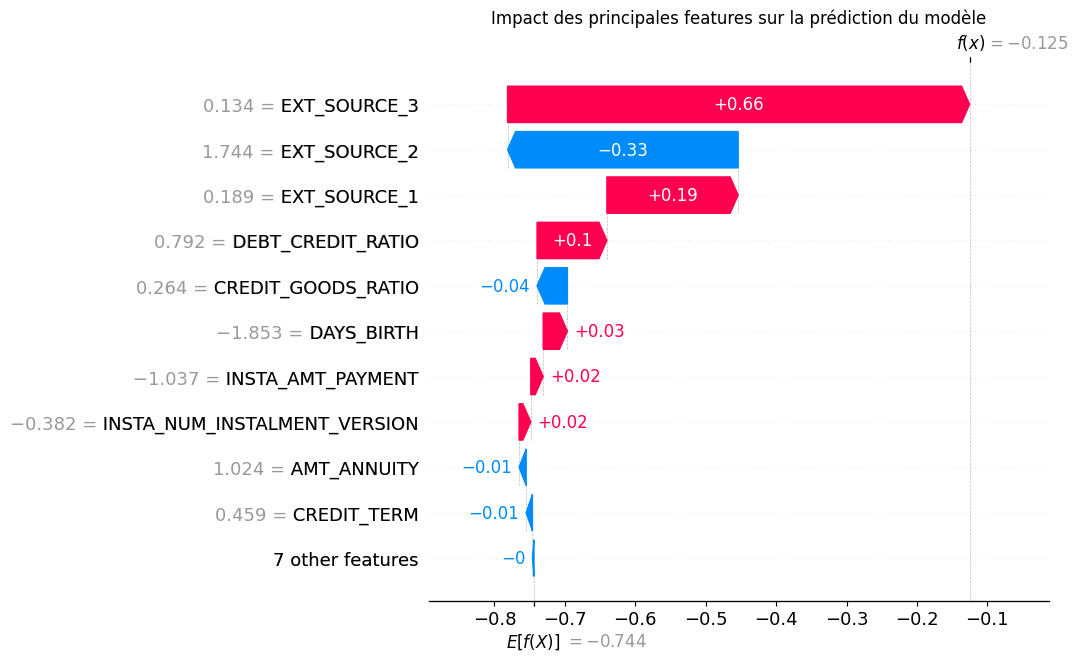

In [10]:
# 📌 Endpoint de l'API pour récupérer les SHAP values
api_shap_url = "http://127.0.0.1:5000/shap_values"

try:
    response = requests.get(api_shap_url)

    if response.status_code == 200:
        shap_data = response.json()

        # 🔍 Extraction des données de l'API
        shap_values = np.array(shap_data["shap_values"]).reshape(1, -1)  # Assurer (1, 17)
        feature_names = shap_data["features_names"]
        sample_values = np.array(shap_data["sample_values"]).reshape(1, -1)  # Même format (1, 17)
        base_values = shap_data["base_values"]

        print("✅ Données SHAP reçues avec succès depuis l'API !")

        # 📌 Vérification des dimensions après correction
        print(f"📌 SHAP values shape : {shap_values.shape}")
        print(f"📌 Feature names count : {len(feature_names)}")
        print(f"📌 Sample values shape : {sample_values.shape}")

        # 📌 Sélection d'un client aléatoire si plusieurs disponibles
        if shap_values.shape[0] > 1:
            random_idx = np.random.randint(0, shap_values.shape[0])
            shap_values = shap_values[random_idx].reshape(1, -1)
            sample_values = sample_values[random_idx].reshape(1, -1)
            print(f"🎲 Client aléatoire sélectionné : {random_idx}")

        # 📌 Création d'un objet SHAP Explanation pour afficher la figure waterfall (comme Streamlit)
        explainer = shap.Explanation(
            values=shap_values[0],  # Prendre la première (et unique) ligne
            base_values=base_values,
            data=sample_values[0],  # Correspondance avec les features
            feature_names=feature_names
        )

        # 📊 Génération et affichage du Waterfall Plot (même rendu que dans Streamlit)
        fig, ax = plt.subplots(figsize=(10, 8))
        shap.waterfall_plot(explainer, max_display=11, show=False)
        plt.title("Impact des principales features sur la prédiction du modèle")
        plt.show()

    else:
        print(f"❌ Erreur lors de l'appel API : {response.status_code}, {response.text}")

except requests.exceptions.RequestException as e:
    print(f"❌ Erreur de connexion à l'API : {e}")

In [11]:
# api_url = "http://127.0.0.1:5000/predict"
# response = requests.post(api_url, json={})

# print(f"🔍 Code HTTP : {response.status_code}")
# print(f"📝 Réponse : {response.text}")

In [ ]:
# print("📌 Features du modèle :", features_list)
# print(type(features_list))
# print("📌 Données envoyées à l'API :", random_sample)

: 

# Commandes